### Titanic dataset

Neste problema vamos tentar prever a probabilidade de sobrevivência dos passageiros com base em seus atributos ou features: Pclass, Sex, Age, Siblings/Spouses Aboard, Parents/Children Aboard e Fare. <br>
A variável binária *Survived* é a variável que estamos querendo prever (também chamada de resposta), sendo Survived = 0 representando um passageiro que não sobreviveu, e Survived = 1 representando um passageiro que sobreviveu. 


### Árvore de decisão

Árvores de decisão são modelos estatísticos de aprendizado supervisionado que utilizam a estratégia dividir para conquistar. Ou seja, um problema complexo é decomposto em sub-problemas mais simples e recursivamente esta técninca é aplicada em cada sub-problema. Esta técnica leva este nome devido a sua estrutura como na imagem abaixo:
<div style="text-align:center"><img src="decision_tree.jpeg" width="345" height="237"></div>

Nesta estrutura de dados, os elementos que armazenam informações chamadas nós, sendo o nó principal (o que se localiza dno topo) é chamado de nó raiz. Os nós abaixo são chamados de nós filhos e o nó que não possui filhos, é chamada de folha. Dessa forma, o aprendizado acontece na elaboração de regras que serão armazenadas em seus nós (regras que definem a próxima quebra), e os nós folhas representam a decisão a ser tomada (no caso do exemplo, se o passageiro vai ou não sobreviver.

### Medidas de Impureza

Na técnica de árvore o algoritmo tem como objetivo encontrar a melhor regra para a quebra de um nó pai nos nós filhos. Sendo a "qualidade" desta quebra podendo ser medida através ganho de informação obtida em cada quebra. Quanto mais informação se ganha ao longo de todas as quebras, ou seja, ao longo da profundidade da árvore, melhor será a tomada de decisão nas folhas.
A medida do ganho de informação pode ser calculada de duas formas:
- Entropia: Mede o grau de (im)pureza dos dados, ou seja, pe uma mendida da falta de homegeneidade dos dados de entrada em relação a sua classificação. Sua fórmula é dada por:
\begin{equation*}
Entropia(s) = \sum_{i=1}^c - p_i log_2 p_i
\end{equation*}
Sendo S um conjunto de dados de entrada, c o número de classes e pi a proporção de dados em S que pertence a classe i

- Gini: Mede o grau de heterogeneidade dos dados, sendo assim, também pode ser utilizadado para medir o grau de impureza de um nó. Sua fórmula é dada por:
\begin{equation*}
Índice Gini = 1 - \sum_{i=1}^c - p_i^2
\end{equation*}
Sendo pi a frequência relativa de cada classe em cada nó.

Em seguida iremos testar as duas metodologias, interpretar os resulatados e realizar a comparação entre eles.

#### Importando bibliotecas

In [1]:
import numpy as np # algebra linear
import pandas as pd # processamento de dados
import matplotlib.pyplot as plt # visualização de dados
import seaborn as sns # visualização de dados estatísticos

C:\Users\carol\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("titanic.csv")

#### Visão geral do conjunto de dados

In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


#### Pré-Processamentos

1. Renomear algumas colunas para simplificar a manipulação do conjunto de dados.
2. Separar o conjunto de dados em treino e teste. Ou seja, vamos usar uma parte dos dados para criar as regras da árvore de decisão, e uma parte dos dados para validar se tais regras discriminam bem a probabilidade de sobrevivência de uma passageiro.

In [5]:
# Renomeia colunas
df = df.rename(columns={"Siblings/Spouses Aboard": "SibSp", "Parents/Children Aboard": "Children"})

# Separa o conjunto de dados em treino e teste
train_df = df.sample(frac=0.8,random_state=200)
test_df = df.drop(train_df.index)

### 1. Análise Exploratória
Faremos uma breve exploração dos dados apenas para nos familizarizar com o conjunto de dados

**Analisando variáveis numéricas:** <br>
Neste caso, foram selecionadas de forma manual quais as variáveis de interesse. Em geral o python já faz essa interpretação, no entanto, a variável "PClass" está sendo interpretada como um número ao invez de uma categoria. O pyton permir mudar o tipo da variável a qualquer momento, mas neste caso prefiri manter desta forma. 

In [6]:
train_df[['Survived','Age','SibSp','Children','Fare']].describe()

,Survived,Age,SibSp,Children,Fare
count,710.000000,710.000000,710.000000,710.000000,710.000000
mean,0.388732,29.515972,0.484507,0.364789,33.451114
std,0.487806,14.222153,0.956995,0.781052,52.114613
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,0.000000,0.000000,7.925000
50%,0.000000,28.000000,0.000000,0.000000,14.458300
75%,1.000000,37.750000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,6.000000,512.329200


Podemos notar que:
- apenas 38% dos passageiros são sobreviventes
- A idade média dos passageiros é de 29 anos sendo o mais novo com 0.4 anos e o mais velho com 80 anos.
- Analisando as descritivas das variáveis SibSp e Children verificamos que em geral os passageiros viajavam sozinhos. Isso devido a baixa média e um valor baixo ou nulo para o percentil 75. 
- A variável fare provavlemente possui uma distribuição não normal, pois o desvio padrão está muito acima da média. 

Text(0.5, 1.0, 'Fare')

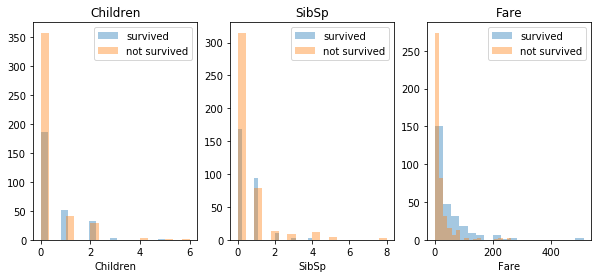

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax= sns.distplot(train_df[train_df["Survived"]==1]['Children'], bins=18, label = 'survived', ax = axes[0], kde = False)
ax =sns.distplot(train_df[train_df["Survived"]==0]['Children'], bins=18, label = 'not survived', ax = axes[0], kde = False)
ax.legend()
ax.set_title('Children')

ax= sns.distplot(train_df[train_df["Survived"]==1]['SibSp'], bins=18, label = 'survived', ax = axes[1], kde = False)
ax =sns.distplot(train_df[train_df["Survived"]==0]['SibSp'], bins=18, label = 'not survived', ax = axes[1], kde = False)
ax.legend()
ax.set_title('SibSp')

ax= sns.distplot(train_df[train_df["Survived"]==1]['Fare'], bins=18, label = 'survived', ax = axes[2], kde = False)
ax =sns.distplot(train_df[train_df["Survived"]==0]['Fare'], bins=18, label = 'not survived', ax = axes[2], kde = False)
ax.legend()
ax.set_title('Fare')

**Analisando variáveis categóricas**

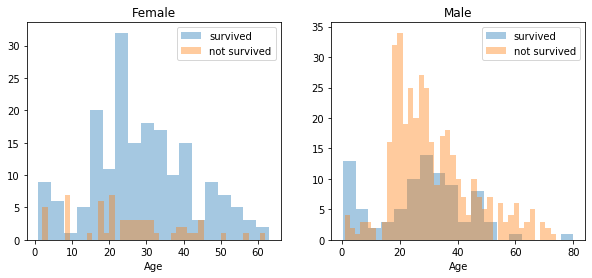

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = 'survived', ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = 'not survived', ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = 'survived', ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = 'not survived', ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

Note uma maior probabilidade de mulheres sobreviverem quando comparado com os homens. Já entre os homens, a maior probabilidade de sobrevivência está da faixa dos 20 aos 40 anos.

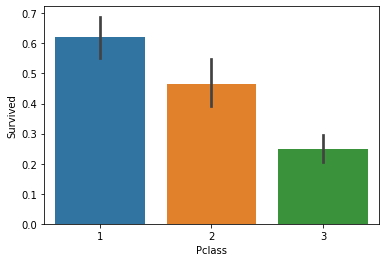

In [10]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

Neste gráfico é possível observar que passageiros da primeira classe tem uma probabilidade de sobrevivênia maior.

### 2. Transformação dos Dados
Nesta etapa vamos trabalhas asa nossas variáveis para que o modelo possa extrair o máximo de informação do conjunto de dados

1. Em geral os modelos não reconhecem estruturas do tipo string, sendo vamos converter a estrutua de string para booleano.

In [11]:
train_df['Sex'] = np.where(train_df['Sex']== 'male', 1, 0)
test_df['Sex'] = np.where(test_df['Sex']== 'male', 1, 0)
train_df['Sex'].value_counts().reset_index()

,index,Sex
0,1,463
1,0,247


2. É uma boa prática passar para o modelo categorias/faixas de valores do que valores contínuos. Este processo é chamado de categorização dos dados.

In [12]:
# Tornando idade em categorias
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

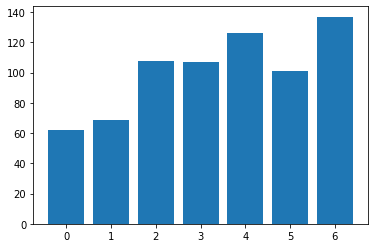

In [13]:
temp = train_df['Age'].value_counts().reset_index()
plt.bar(temp['index'],temp['Age'])
plt.show()

In [14]:
# Tornando títulos em categoria
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [15]:
# Tornando "fare" em categoria
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

3. A criação de algumas variáveis baseadas nas existentes também é uma boa prática. Dessa forma podemos apresentar para a árvore de decisão informações cruzadas e/ou agrupadas.

In [16]:
# Vamos criar variáveis que consolidam a quantidade de parentes de um passageiro
# E uma outra mais resumida dizendo apenas se o mesmo se encontra sozinho ou não
data = [train_df, test_df]
for dataset in data:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Children']
    dataset.loc[dataset['Relatives'] > 0, 'NotAlone'] = 0
    dataset.loc[dataset['Relatives'] == 0, 'NotAlone'] = 1
    dataset['NotAlone'] = dataset['NotAlone'].astype(int)
train_df['NotAlone'].value_counts()

1    427
0    283
Name: NotAlone, dtype: int64

Verificando o novo conjunto de dados

In [17]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Children,Fare,Title,Relatives,NotAlone
45,0,3,1,2,1,0,2,0.0,1,0
261,0,1,1,5,0,0,0,0.0,0,1
478,0,2,1,5,0,0,0,0.0,0,1
129,0,3,1,4,0,0,0,0.0,0,1
553,1,1,0,6,1,0,3,0.0,1,0
30,0,1,1,5,0,0,2,0.0,0,1
39,1,3,0,1,1,0,1,0.0,1,0
359,0,2,1,4,1,0,2,0.0,1,0
88,0,3,1,3,0,0,1,0.0,0,1
671,0,2,1,2,0,0,0,0.0,0,1


### 3 Modelagem

Utilizaremos a biblioteca do _sklearn_ para modelar a árvore de decisão. Para avaliação (na base de teste) utilizaremos o critério de acurácia e matriz de confusão 

Para a visualização da árvore usaremos as bibliotecas do pacote _graphviz_

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot

C:\Users\carol\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Esta biblioteca possui os seguintes parâmetros implementados:

- critério: gini ou entropia
- splitter: decide qual variável a ser analisada para a quebra
- max_depth: Profundidade da árvore. Default = None o que siginifica que os nós vão expandir até a máxima pureza das folhas.
- min_samples_split: Número mínimo de amostras para que ocorra uma quebra.
- min_samples_leaf: Número mínimo de amostras em cada folha.
- min_weight_fraction_leaf: Peso em cada folha (ideal para base de dados desbalanceadas)
- max_features: Número de atributos a serem considerados para deterinar uma quebra.
- min_impurity_decrease: redução mínima de impureza em cada quebra.
- min_impurity_split: Medida de impureza para critério de parada.

Para auxiliar no preenchimento das variáveis o python possui um recurso chamado _GridSearch_ que basicamente faz uma busca pelo melhor parâmetro dentro de um range determidado

### 3.1 Modelo de árvore utilizando Gini

In [19]:
# Separando a resposta do dataset
X_train = train_df.drop(['Survived'], axis = 1)
y_train = train_df['Survived']
X_test = test_df.drop(['Survived'], axis = 1)
y_test = test_df['Survived']

In [20]:
from sklearn.model_selection import GridSearchCV

params = {
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

clf_gini = GridSearchCV(
    DecisionTreeClassifier(random_state=42, criterion='gini'),
    params, scoring="accuracy", n_jobs=-1, cv=3)

In [21]:
clf_gini.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18,

In [22]:
y_pred_gini = clf_gini.predict(X_test)

In [23]:
print('Acurácia do modelo utilizando gini: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))
print('Matriz de confusão\n\n', confusion_matrix(y_test, y_pred_gini))

Acurácia do modelo utilizando gini: 0.8136
Matriz de confusão

 [[102   9]
 [ 24  42]]


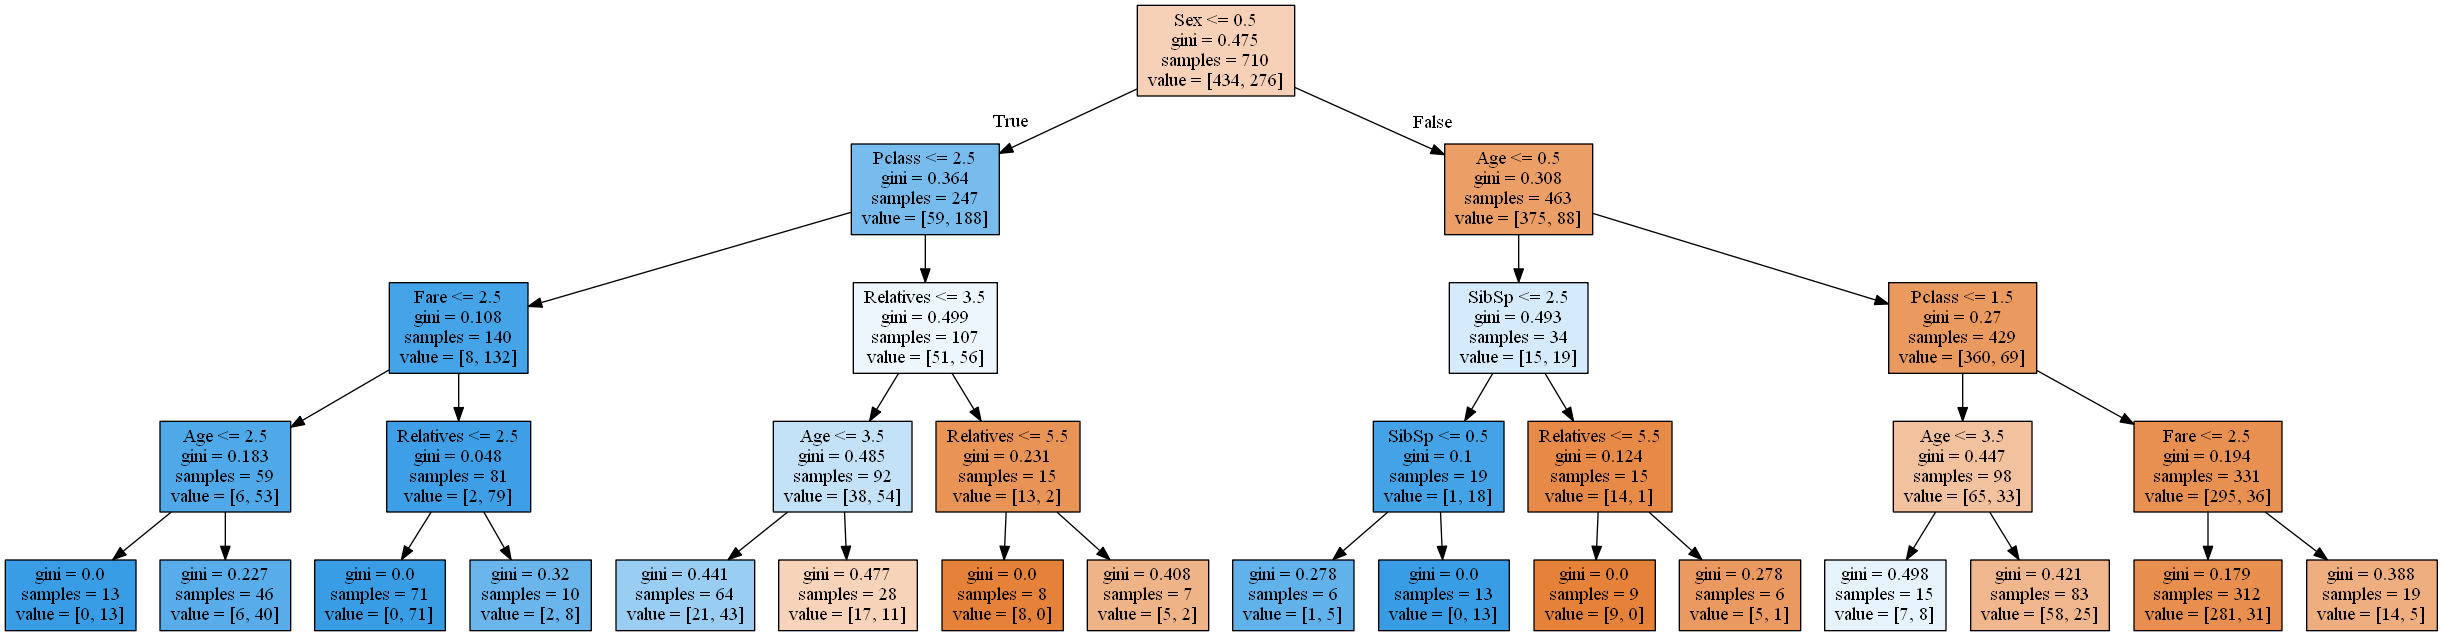

In [24]:
features = list(X_train.columns)
dot_data = StringIO()
export_graphviz(clf_gini.best_estimator_, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

### 3.2 Modelo de árvore utilizando Entropia

In [25]:
params = {
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

clf_en = GridSearchCV(
    DecisionTreeClassifier(random_state=42, criterion='entropy'), 
    params, scoring="accuracy", n_jobs=-1, cv=3)

clf_en.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 

In [26]:
y_pred_en = clf_en.predict(X_test)

In [27]:
print('Acurácia do modelo utilizando entropia: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))
print('Matriz de confusão\n\n', confusion_matrix(y_test, y_pred_en))

Acurácia do modelo utilizando entropia: 0.8305
Matriz de confusão

 [[101  10]
 [ 20  46]]


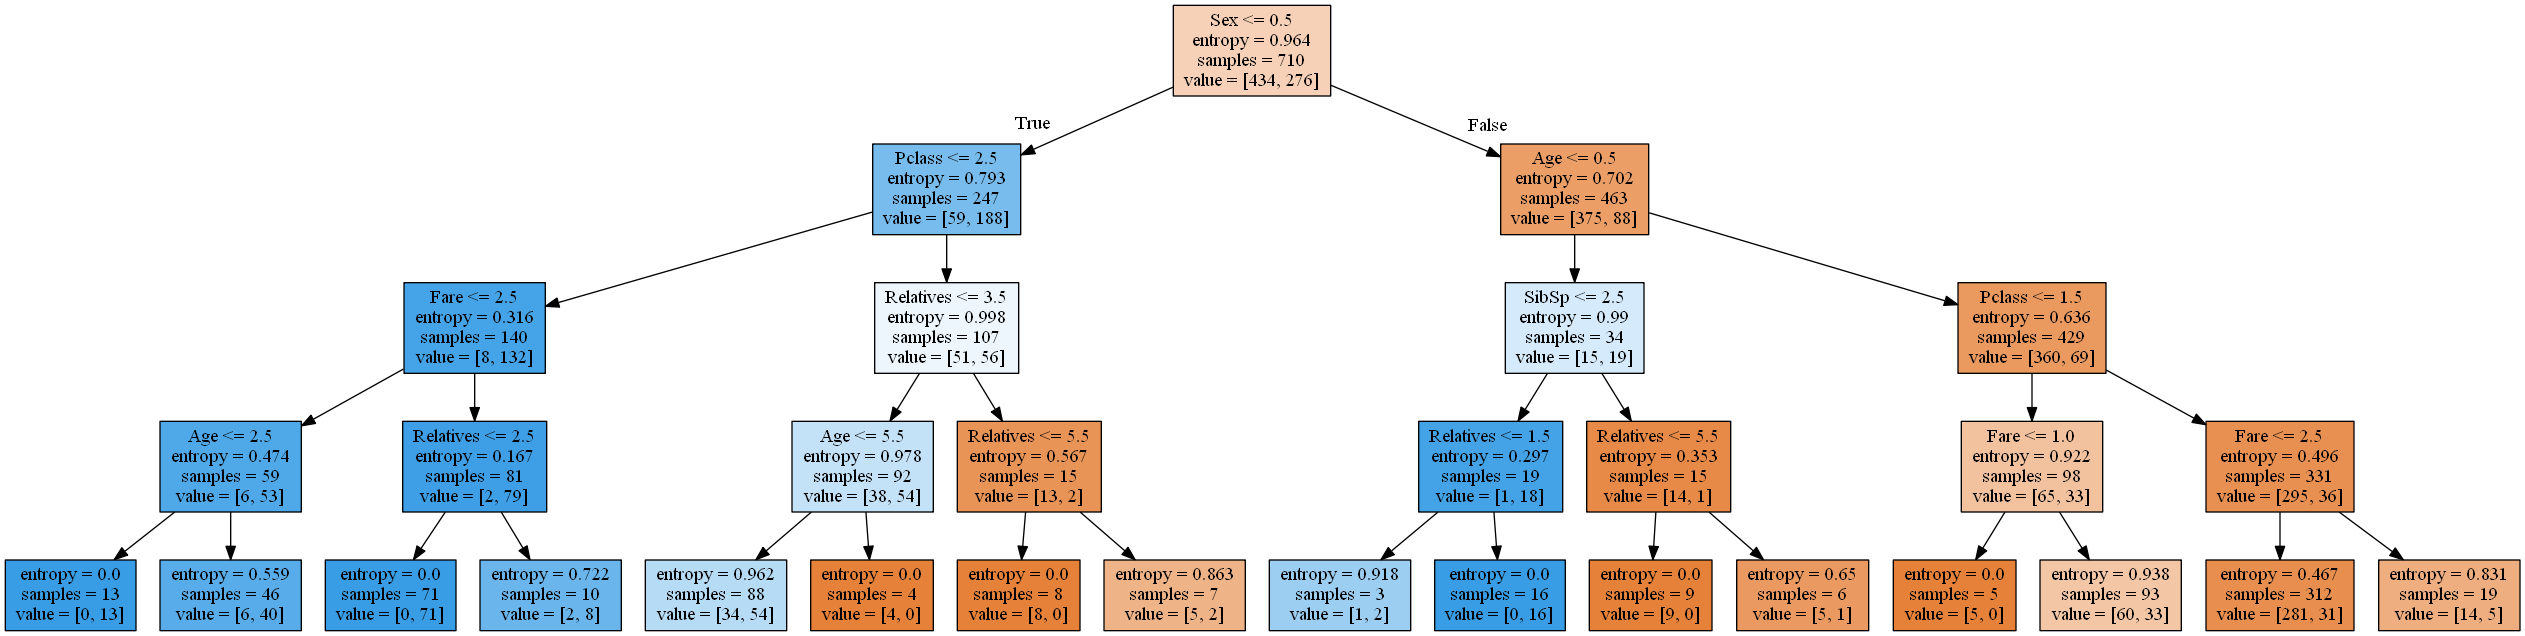

In [28]:
features = list(X_train.columns)
dot_data = StringIO()
export_graphviz(clf_en.best_estimator_, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())